In [1]:
# Math 551: uMass Amherst Fall 2022

import numpy as np
import scipy as sp
import scipy.linalg as LA

import math
import matplotlib.pyplot as plt

from prettytable import PrettyTable, MARKDOWN

## Poisson's Equations

The test program in this notebook is the Poisson equation
$$ 
\frac{\partial^2 u}{\partial x^2} + \frac{\partial^2 u}{\partial y^2} = -g(x, y)
$$

with Dirichlet boundary conditions.

In [2]:
import scipy.sparse as sps

# Disc points
L = 1
N = 4
h = 1./(N-1)

# Create differentiation matrices
D2 = sps.diags([-1, 2, -1], [-1, 0, 1], shape=(N, N))

# Now assemble 2D matrices
Ix = sps.eye(N)
Iy = sps.eye(N)

D2_x = sps.kron(Ix, D2)
D2_y = sps.kron(D2, Iy)
D2   = D2_x + D2_y

print(D2.shape)

(16, 16)


In [4]:
# Implement a Poisson solver 
# 1. Implement a LinearOperator that represents the finite difference matrix.
from scipy.sparse.linalg import LinearOperator

class Laplacian(LinearOperator):
    """ Poisson operator """
    def __init__(self, N, dtype=None, *args, **kwargs):
        """ N is the grid size """
        L = kwargs.pop('L', 1.)
        self.h = L / (N - 1)
        
        # Create differentiation matrices
        D2 = sps.diags([-1, 2, -1], [-1, 0, 1], shape=(N, N))
        
        # Now assemble 2D matrices
        Ix = sps.eye(N)
        Iy = sps.eye(N)
        
        D2_x = sps.kron(Ix, D2)
        D2_y = sps.kron(D2, Iy)
        self.D2   = D2_x + D2_y 

        # Call constructor of base
        super().__init__(dtype=np.dtype(dtype), shape=(N**2, N**2))
        
    def _matvec(self, x):
        """ Computes Laplacian using central finite difference scheme """
        return self.D2 @ x

In [5]:
def create_problem(N, L=2.*np.pi):
    
    def g(x, y):
        return np.cos(2. * x) + np.cos(2. * y) + np.cos(x) * np.cos(y)
    
    # Now we have Dirichlet BCs -> only need to solve on the internal grid.
    # uniform points in both directions
    x = np.linspace(0, L, N)
    xx, yy = np.meshgrid(x[1:-1], x[1:-1])
    
    # Create right hand vector
    gij = g(xx, yy).flatten()
    
    # Create Laplacian
    LN = Laplacian(N-2, L=L)
    h  = L / (N - 3)
    
    # Return the system
    return LN, h**2 * gij
 

def plot_soln(xs, L=2.*np.pi):
    N2 = int(np.sqrt(xs.shape[0]))
    N = N2 + 2
    # Plot the solution
    x = np.linspace(0, L, N)
    xx, yy = np.meshgrid(x, x)
    zz = np.zeros_like(xx)
    zz[1:-1, 1:-1] = xs.reshape((N-2, N-2))
    
    plt.pcolormesh(xx, yy, zz)
    plt.xlim([0, L])
    plt.ylim([0, L])
    plt.xlabel('$x$')
    plt.ylabel('$y$')
    plt.colorbar()

## Jacobi Method

In [6]:
b1 = 1.0
b2 = 1.0
xr = np.ones(2)

def Jacobi(x):
    x1, x2 = x
    
    return np.array([
        0.5 * (x2 + 1),
        0.5 * (x1 + 1)
    ])


x = np.zeros(2)
for i in range(5):
    x = Jacobi(x)
    print('x[{0:d}] = {1:.4g}, {2:.4g}, {3:.4g}'.format(i, x[0], x[1], np.max(np.abs(x - xr))))

x[0] = 0.5, 0.5, 0.5
x[1] = 0.75, 0.75, 0.25
x[2] = 0.875, 0.875, 0.125
x[3] = 0.9375, 0.9375, 0.0625
x[4] = 0.9688, 0.9688, 0.03125


In [4]:
b1 = 3.0
b2 = -3.0
xr = np.ones(2)
xr[1] = -1

def Jacobi(x):
    x1, x2 = x
    
    return np.array([
        0.25 * (3 - x2),
        -0.25 * (x1 + 3)
    ])


x = np.zeros(2)
for i in range(5):
    x = Jacobi(x)
    print('x[{0:d}] = {1:.4g}, {2:.4g}, {3:.4g}'.format(i, x[0], x[1], np.max(np.abs(x - xr))))

x[0] = 0.75, -0.75, 0.25
x[1] = 0.9375, -0.9375, 0.0625
x[2] = 0.9844, -0.9844, 0.01562
x[3] = 0.9961, -0.9961, 0.003906
x[4] = 0.999, -0.999, 0.0009766


## Gauss-Seidel 

In [7]:

b1 = 1.0
b2 = 1.0
xr = np.ones(2)

def GS(x):
    x1, x2 = x
    
    xk1 = 0.5 * (x2 + 1)
    return np.array([
        xk1, 
        0.5 * (xk1 + 1.0)
    ])


x = np.zeros(2)
for i in range(5):
    x = GS(x)
    print('x[{0:d}] = {1:.4g}, {2:.4g}, {3:.4g}'.format(i, x[0], x[1], np.max(np.abs(x - xr))))

x[0] = 0.5, 0.75, 0.5
x[1] = 0.875, 0.9375, 0.125
x[2] = 0.9688, 0.9844, 0.03125
x[3] = 0.9922, 0.9961, 0.007812
x[4] = 0.998, 0.999, 0.001953


In [5]:
b1 = 3.0
b2 = -3.0
xr = np.ones(2)
xr[1] = -1

def GS(x):
    x1, x2 = x
    
    return np.array([
        0.25 * (3 - x2),
        (x2 - 15)/16.
    ])


x = np.zeros(2)
for i in range(5):
    x = GS(x)
    print('x[{0:d}] = {1:.4g}, {2:.4g}, {3:.4g}'.format(i, x[0], x[1], np.max(np.abs(x - xr))))

x[0] = 0.75, -0.9375, 0.25
x[1] = 0.9844, -0.9961, 0.01562
x[2] = 0.999, -0.9998, 0.0009766
x[3] = 0.9999, -1, 6.104e-05
x[4] = 1, -1, 3.815e-06


## SOR

In [8]:
b1 = 1.0
b2 = 1.0
xr = np.ones(2)

# SOR parameter omega in (1, 2)
omega = 1.5

def SOR(x):
    x1, x2 = x
    
    # Do the GS step
    xk1 = 0.5 * (x2 + 1.)
    xk2 = 0.5 * (xk1 + 1.)
    
    # Then do SOR
    xk1_SOR = (1. - omega) * x1 + omega * xk1
    xk2_SOR = (1. - omega) * x2 + omega * xk2
    
    return np.array([xk1_SOR, xk2_SOR])


x = np.zeros(2)
for i in range(5):
    x = SOR(x)
    print('x[{0:d}] = {1:.4g}, {2:.4g}, {3:.4g}'.format(i, x[0], x[1], np.max(np.abs(x - xr))))

x[0] = 0.75, 1.125, 0.25
x[1] = 1.219, 0.9844, 0.2188
x[2] = 0.8789, 1.002, 0.1211
x[3] = 1.062, 0.9998, 0.06201
x[4] = 0.9688, 1, 0.03119


# Gradient Descent

In [9]:
import scipy.sparse as sps
from scipy.sparse.linalg import LinearOperator
#from pylops import LinearOperator

class MatrixVectorProduct(LinearOperator):
    def __init__(self, A, dtype=None):
        self.A = A
        super().__init__(dtype=np.dtype(dtype), shape=A.shape)
        
    def _matvec(self, x):
        """ Implements the matrix vector product """
        return self.A @ x
    
# Example
A = np.array([[7, 3, 1], [3, 10, 2], [1, 2, 15]])
b = np.array([28, 31, 22])
# Solution is [3, 2, 1]

# Create the linear operator
Ax = MatrixVectorProduct(A)

Ax =  [ 2 -8]


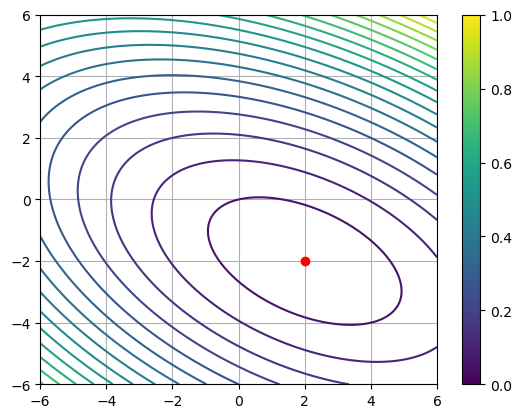

In [10]:
import numpy as np
import matplotlib.pyplot as plt 

A = np.array([[3, 2], [2, 6]])
b = np.array([2, -8])
c = 0
x = np.array([2, -2])
print('Ax = ', A @ x)

def f(x, y):
    return 0.5 * (3. * x**2 + 4. * x * y + 6 * y**2) - 2 * x + 8 * y

xs = np.linspace(-6, 6, 1000)
xx, yy = np.meshgrid(xs, xs)
plt.contour(xx, yy, f(xx, yy), 25)
plt.scatter(2, -2, color='r', zorder=5)
plt.grid()
plt.colorbar()

In [12]:

def gdesc(A, b, tol=1e-12, norm=lambda x: LA.norm(x, ord=2), *args, **kwargs):
    # make sure types are right
    A = sps.linalg.aslinearoperator(A)
    b = b.astype(float)

    # In this case we know what r will be!
    xk = kwargs.pop('x0', np.zeros_like(b))
    rk = b - A.matvec(xk)
    dk = np.dot(rk, rk)
    bd = np.dot(b, b)
    k = 0
    
    pts = [xk]
    
    while dk > tol*tol*bd:
        sk = A.matvec(rk)
        ak = dk / np.dot(rk, sk)
        xk = xk + ak * rk
        pts.append(xk)
        rk = rk - ak * sk
        dk = np.dot(rk, rk)
        k += 1
        
    return xk, norm(rk), k, pts

# Example
# A = np.array([[7, 3, 1], [3, 10, 2], [1, 2, 15]])
# b = np.array([28, 31, 22])
# Solution is [3, 2, 1]

# Create the linear operator
Ax = MatrixVectorProduct(A)

# Test the method
x, r, k, pts = gdesc(Ax, b)

print('||B - Ax|| = ', np.max(np.abs(A @ x - b)))
print('x = ', x)
print('r = ', r)
print('k = ', k)

||B - Ax|| =  5.019540338935258e-12
x =  [ 2. -2.]
r =  5.1741851798292685e-12
k =  47


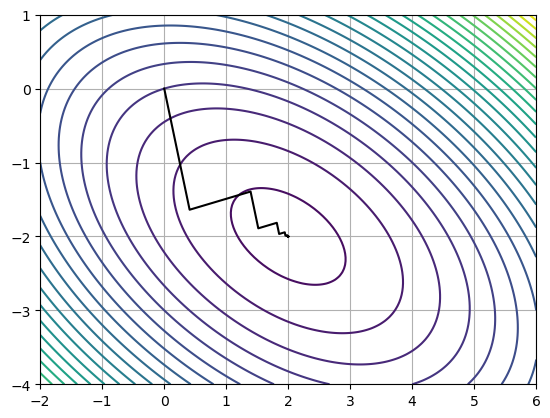

In [13]:
pts = np.asarray(pts)
xs = np.linspace(-2, 6, 1000)
ys = np.linspace(-4, 1, 100)
xx, yy = np.meshgrid(xs, ys)
plt.contour(xx, yy, f(xx, yy), 25)
plt.plot(pts[:, 0], pts[:, 1], color='k')
plt.grid()

# Conjugate gradient

In [14]:

def cg(A, b, tol=1e-12, norm=lambda x: LA.norm(x, ord=2), *args, **kwargs):
    # make sure types are right
    A = sps.linalg.aslinearoperator(A)
    b = b.astype(float)

    # In this case we know what r will be!
    xk = kwargs.pop('x0', np.zeros_like(b))
    rk = b - A.matvec(xk)
    dk = np.dot(rk, rk)
    bd = np.dot(b, b)
    pk = rk.copy()
    pts = [xk]
    ps = [pk]
    k = 0
    
    while dk > tol*tol*bd:
        sk = A.matvec(pk)
        ak = dk / np.dot(pk, sk)
        xk = xk + ak * pk
        pts.append(xk)
        rk = rk - ak * sk
        dk1 = np.dot(rk, rk)
        pk = rk + (dk1 / dk) * pk
        ps.append(pk)
        dk = dk1
        k += 1
        
    return xk, norm(rk), k, pts, ps

# Example
# A = np.array([[7, 3, 1], [3, 10, 2], [1, 2, 15]])
# b = np.array([28, 31, 22])
# Solution is [3, 2, 1]

# Create the linear operator
Ax = MatrixVectorProduct(A)

# Test the method
x, r, k, pts, ps = cg(Ax, b)

print('||B - Ax|| = ', np.max(np.abs(A @ x - b)))
print('x = ', x)
print('r = ', r)
print('k = ', k)

||B - Ax|| =  0.0
x =  [ 2. -2.]
r =  9.930136612989092e-16
k =  2


[[ 2.42535625e-01 -9.70142500e-01]
 [ 9.75132856e-01 -2.21621104e-01]
 [-8.88178420e-16 -4.44089210e-16]]


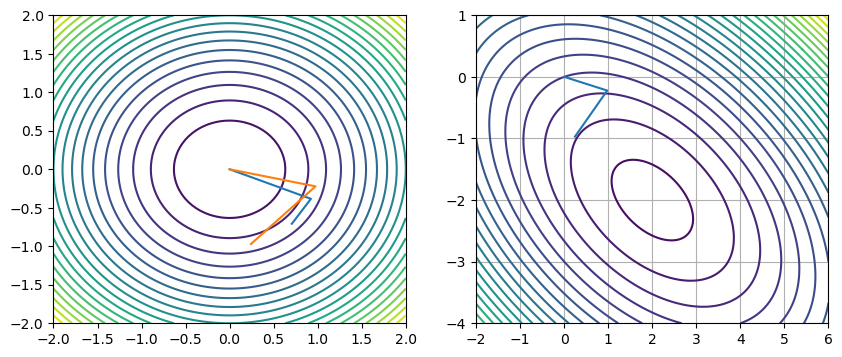

In [15]:
A1 = (1./14) * np.array([[6, -2], [-2, 3]])
pts = np.asarray(pts)

ps = np.asarray(ps)
qs = np.zeros_like(ps)
for i in range(ps.shape[1]):
    ps[i, :] /= np.linalg.norm(ps[i, :], ord=2)
    qs[i, :] = A1 @ ps[i, :]
    qs[i, :] /= np.linalg.norm(qs[i, :], ord=2)

fig, axs = plt.subplots(1, 2, figsize=(10, 4))

xs = np.linspace(-2, 2, 100)
ys = np.linspace(-2, 2, 100)
xx, yy = np.meshgrid(xs, ys)

axs[0].contour(xx, yy, xx**2 + yy**2, 25)
axs[0].plot(qs[:, 0], qs[:, 1])
axs[0].plot(ps[:, 0], ps[:, 1])

xs = np.linspace(-2, 6, 1000)
ys = np.linspace(-4, 1, 100)
xx, yy = np.meshgrid(xs, ys)

axs[1].contour(xx, yy, f(xx, yy), 25)
axs[1].plot(ps[:, 0], ps[:, 1])
print(ps)
plt.grid()

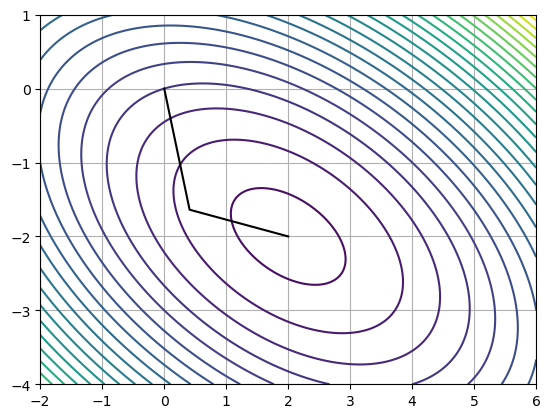

In [16]:
pts = np.asarray(pts)
xs = np.linspace(-2, 6, 1000)
ys = np.linspace(-4, 1, 100)
xx, yy = np.meshgrid(xs, ys)
plt.contour(xx, yy, f(xx, yy), 25)
# Plot path
plt.plot(pts[:, 0], pts[:, 1], color='k')
plt.grid()

# Gradient Descent 2D Poisson

Linear system solved in 18566 iterations with ||r|| = 7.3953e-13.


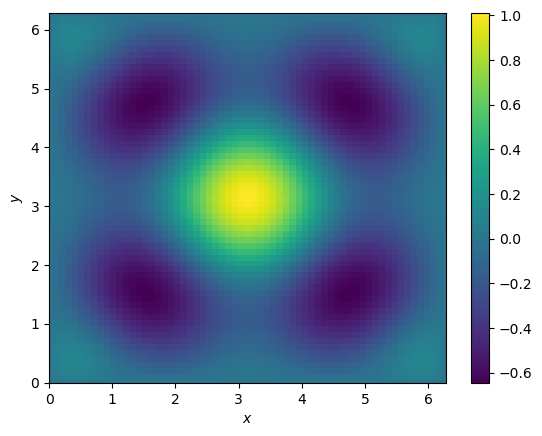

In [25]:
L, b = create_problem(N=63)

# Solve the linear system
xs, r, k, _ = gdesc(L, b, tol=1e-12)

print('Linear system solved in {0:d} iterations with ||r|| = {1:.5g}.'.format(k, r))

plot_soln(xs)

### Conjugate gradient and Poisson

(3721, 3721)
Linear system solved in 140 iterations with ||r|| = 4.9752e-13.


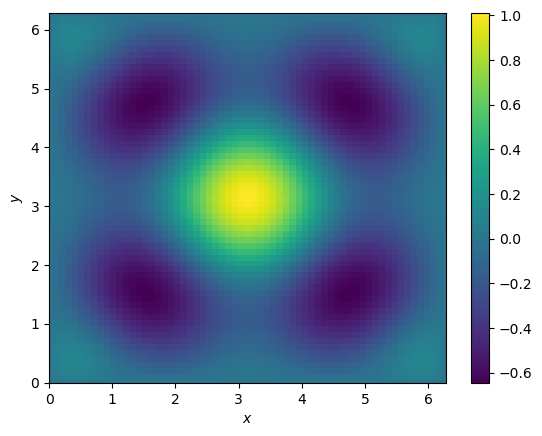

In [26]:
L, b = create_problem(N=63)

print(L.shape)

# Solve the linear system
xs, r, k, _, _ = cg(L, b, tol=1e-12)

print('Linear system solved in {0:d} iterations with ||r|| = {1:.5g}.'.format(k, r))

plot_soln(xs)

## Preconditioned conjugate gradient

In [19]:
def pcg(A, P, b, tol=1e-12, norm=lambda x: LA.norm(x, ord=2), *args, **kwargs):
    # make sure types are right
    A = sps.linalg.aslinearoperator(A)
    b = b.astype(float)
    
    # In this case we know what r will be!
    xk = kwargs.pop('x0', np.zeros_like(b))
    rk = b - A.matvec(xk)
    hk = P.solve(rk)
    dk = np.dot(rk, hk)
    bd = np.dot(b, P.solve(b))
    pk = hk.copy()
    k = 0
    
    while dk > tol*tol*bd:
        sk = A.matvec(pk)
        ak = dk / np.dot(pk, sk)
        xk = xk + ak * pk
        rk = rk - ak * sk
        hk = P.solve(rk)
        dk1 = np.dot(rk, hk)
        pk = hk + (dk1 / dk) * pk
        dk = dk1
        k += 1
        
    return xk, norm(rk), k

# Example
A = np.array([[7, 3, 1], [3, 10, 2], [1, 2, 15]])
b = np.array([28, 31, 22])
# Solution is [3, 2, 1]

# Create the linear operator
Ax = MatrixVectorProduct(A)

# Create the preconditioner by defauly uses ILU -> TODO symmetrify i.e. Cholesky
P = sps.linalg.spilu(A, drop_tol=1e-2)

# Test the method
x, r, k = pcg(Ax, P, b)

print('||B - Ax|| = ', np.max(np.abs(A @ x - b)))
print('x = ', x)
print('r = ', r)
print('k = ', k)

||B - Ax|| =  7.105427357601002e-15
x =  [3. 2. 1.]
r =  8.702335715267317e-15
k =  1


/usr/lib/python3.10/site-packages/scipy/sparse/linalg/_dsolve/linsolve.py:437: SparseEfficiencyWarning: spilu converted its input to CSC format
  warn('spilu converted its input to CSC format',


Solve!
Linear system solved in 365 iterations with ||r|| = 4.0499e-12.


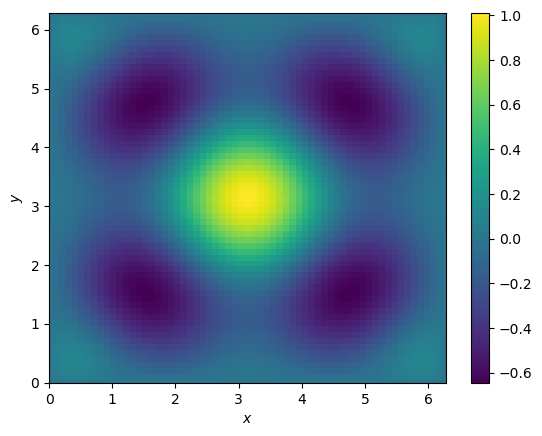

In [24]:
L, b = create_problem(N=63)

# Assemb    le a precond
P = sps.linalg.spilu(L.D2.tocsc(), drop_tol=0.01)

print('Solve!')

# Solve the linear system
xs, r, k = pcg(L, P, b, tol=1e-12)

print('Linear system solved in {0:d} iterations with ||r|| = {1:.5g}.'.format(k, r))

plot_soln(xs)

## Multigrid preconditioned conjugate gradient

http://www.hpcs.cs.tsukuba.ac.jp/~tatebe/research/paper/CM93-tatebe.pdf

Let's learn something about multigrid methods. The equation at grid level $i$ is given by

$$ A_i \mathbf{x}_i = b_i $$ 

We also need to transfer maps: (1) The *restriction* map which maps a vector from a finer grid to a coarsers grid denoted by $r$, and (2) the *prolongation* operator which maps coarser grids to finer grids, denoted by $p$. 

The restriction operator is defined as the adjoint of prolongation, that is, it satisfies
$$ r = b p^T $$ 
where $b$is a scalar constant.

### Two-grid methods

A linear equation $A_l \mathbf{x}_l = b_l$ is considered. Let $R$ be the relaxant matrix and $\mathbf{u}$ is an approximate vector.

1. Relaxation $\mathbf{u} = H^m \mathbf{u} + R \mathbf{f}$
2. Coarse-grid correction $\mathbf{d} = r\left(L_l \mathbf{u} - \mathbf{f} \right)$
3. $\mathbf{v} = L_{l-1}^{-1} \mathbf{d}$
4. Map back to fine grid $\mathbf{u} = \mathbf{u} - p \mathbf{v}$
5. Post-smoothing step $\mathbf{u} = H^m \mathbf{u} + R \mathbf{f}$

Let's split the matrix as follows
$$A_i = P - Q$$ 
when using Jacobi P will contain the diagonal eleemnts. Then update the vector
$$
u^{i+1} = P^{-1}Q u^i + P^{-1} f
$$ 
We do $m$ iterations of this. Then the matrix representing these iterations is given by $H$.




In [ ]:
# Poisson equation
N = 4
D1 = sps.diags([-1, 2, -1], [-1, 0, 1], shape=(N, N))
print(type(D1))
print(D1.todense())

D2_x = sps.diags([-1, 2, -1], [-1, 0, 1], shape=(N, N))
D2_y = sps.diags([-1, 2, -1], [-1, 0, 1], shape=(N, N))
D2   = sps.kron(sps.eye(N), D2_x) + sps.kron(D2_y, sps.eye(N))
D2   = D2.todia()

In [ ]:
# Inter grid operations in 1D

# Define prolongation operation
# I_H^h : Omega_H -> Omega_h

# [x_0, x_1, ..., x_{N+1}]
# Number of internal points is odd -> N-1 odd -> N+1 odd -> N even
N = 5

# v^h = I_2h^h v^{2h}
# v^h_2j   = 2_j^2h
# v^h_2j+1 = (v^2h_j + v^2h_j+1) / 2
I = sps.lil_array((N+2, (N+1)//2))

cc = np.array([1, 2, 1])
for k in range((N+1)//2):
    kk = 2*k
    I[kk:kk+3, k] = cc

# Scale
I = I[1:-1, :]
I *= 0.5

# Cmpute inverse
R = I.transpose()
R *= 0.5
R[0, 1] = 0.
R[-1, -2 ] = 0.
R[0, 0] *= 2.
R[-1, -1] *= 2

print('I = ')
print(I.todense())

print()
print('R = ')
print(R.todense())


In [ ]:
xs = np.linspace(0, 1, (N+1)//2)

plt.scatter(xs, np.zeros_like(xs), color='r')

ys = I @ xs

zs = R @ ys

print(xs)
print(ys)
print(zs)

plt.scatter(ys, .1 *np.ones_like(ys), color='b')

plt.scatter(zs, .2 *np.ones_like(zs), color='k')

plt.ylim([-0.1, .3])

In [ ]:
def smooth(steps, A, x0, f):
    # TODO implement damped Jacobi / GS.
    for i in range(steps):
        x0 += B @ (f - A @ x0)
    
    return x0

In [ ]:
# 2D interpolation matrix is the tensor product of the interpolator 
# in both directions
I2D = sps.kron(I, I)

# Test set
x   = np.linspace(0, 1, 3)
y   = np.linspace(0, 1, 3)
xx, yy = np.meshgrid(x, y)

print(I2D.shape)
print(xx.shape)

A = np.arange(9).reshape((3, 3))
plt.pcolormesh(xx, yy, A)

plt.colorbar()


In [ ]:
# Test set
x   = np.linspace(0, 1, 5)
y   = np.linspace(0, 1, 5)
xx, yy = np.meshgrid(x, y)

B = I2D @ A.flatten()

plt.pcolormesh(xx, yy, B.reshape((5, 5)))
plt.colorbar()

## AMG basics

Solve $$ Au = f$$ 

In [ ]:
# CF based AMG -> get strength matrix
def CfStrength(A):
    n, m = A.shape
    assert n == m, ''
    
    

In [ ]:
from sympy import pycode, tan, Symbol, srepr, N, sympify, lambdify

x = Symbol('x')

expr_str = 'tan(x) + 1'
expr1 = sympify(expr_str)

# lam_str = lambdastr(x, expr1)

print(lam_str)

lam = lambdify(x, expr1)

print(lam(1))

py_str = pycode(expr1)
print('Python code = ')
print(py_str)




In [ ]:
expr = tan(x) + 1

# Slow symp eval
res = expr.subs(x, 2)

print(res)
print(N(res))


srepr(expr)